# Overview of Assignment 3

This assignment focuses on exploring and implementing advanced concepts and techniques in information retrieval and recommender systems. The primary objectives are to develop a semantic search engine using Artificial Neural Networks (ANNs), explore alternative models for text search, and design a recommender system based on lecture transcripts.

#   Enter your details below

# Name

Avijit Karmoker

# Banner ID

 B00825518

# Q1: Setting up the libraries and environment

In [1]:
!pip install transformers
import torch
from transformers import BertTokenizer, BertModel

import json



# Q2: Semantic Search using ANN for Text-to-Text with Annoy

#Answer to Question: (2a)

Firstly, we break down the text into tokens which then is converted into numerical IDs using vocabulary.

Secondly, these tokens are then fed into the neural network model, ANN. The model encodes these tokens into token embeddings that contextually represents these tokens meanings.

Thirdly, it gathers all these token embeddings. The pretrained model, ANN, which is trained so that these embeddings are positioned around the vector space which is close proximity and have the similar meaning.  



# Answer to question: (2b)

In [ ]:
# function that generates vector embeddings

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


def generate_embeddings_for_text(texts):
    text_embeddings = []
    for each_text in texts:
        tokenized_text = tokenizer.tokenize(each_text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        segments_ids = [1] * len(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])
        with torch.no_grad():
            outputs = model(tokens_tensor, segments_tensors)
            # we extract the last hidden state
            last_hidden_states = outputs[0]

            # we get the embeddings for each token
            token_embeddings = last_hidden_states.squeeze(0)

            token_vecs = []
            for token in token_embeddings:
                token_vecs.append(token)

        # We take average of the token embeddings to get a single vector for the text
        text_embedding = torch.stack(token_vecs).mean(dim=0)
        text_embeddings.append(text_embedding)

    # we convert the list of embeddings for each text into a single tensor and return 2D tensor
    return torch.stack(text_embeddings)


# text taken from https://www.lipsum.com/, 20 July 2025

my_text = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum"]
my_text_embeddings = generate_embeddings_for_text(my_text)
print(my_text_embeddings.shape)

torch.Size([1, 768])


#Answer to Question: (2c)

Here is how the Annoy Library is used:

i) It builds forest of trees for the vector space partition

ii) Annoy then builds the number of trees we wish to build and specify unique IDs for each tree.

iii) Search becomes easier as Annoy only matches the query vector with the vector which is the subset of the trees

iv) it then stores the index on disc to reload later if required and save the time on search.

#Answer to Question: (2d)

In [ ]:
# function that builds Annoy Index
!pip install annoy --quiet
import annoy
from annoy import AnnoyIndex
import numpy as np

def build_annoy_index(embeddings, num_trees=10):
  annoy_index = AnnoyIndex(embeddings.shape[1], 'angular')
  for i in range(embeddings.shape[0]):
    annoy_index.add_item(i, embeddings[i].detach().numpy())

  annoy_index.build(num_trees)
  annoy_index.save('annoy_index.ann')

  return annoy_index

my_annoy_index = build_annoy_index(my_text_embeddings)

# Answer to question: (2e)

Here is the process of Semantic search using Annoy library and saved vector embeddings:

i) We convert the query text into embeddings using the ANN model and gather the query embeddings

ii) We then use the Annoy Library to search with the query vector and return the IDs of the closes vectors

iii) We then retrive the results by mapping those IDs into the original document.

# Answer to question: (2f)

In [ ]:
# implementation of function:

def semantic_search(query_text, annoy_index, text, num_results=3):
  query_embeddings = generate_embeddings_for_text([query_text])[0]
  search_results_IDs = annoy_index.get_nns_by_vector(query_embeddings, num_results)
  search_results = [text[i] for i in search_results_IDs]

  return search_results

text = my_text
my_results = semantic_search("What is dummy text?", my_annoy_index, text, num_results=2)
print(my_results)

["Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum"]


# Answer to Question: (2g)

Advantages of using using Annoy with ANNs for semantic search
compared to traditional keyword-based search methods are as follows:

i) It can find documents with similar meanings

ii) very fast retriaval

Limitations:

i) Computational cost is comparatively higher than traditional keyword-based search

ii) It generates close results not exact

# Q3 Searching Images with Text

#Answer to question: (3a)

Alternative models to CLIP model that could be used to search images with text are:

i) ALIGN : It also aligns image-text pairs. However, its was better zero-shot retrieval performance on large datasets.

ii) BLIP: This also aligns image-text but also generates captions as well.



#Answer to question: (3b)

100%|██████████| 272/272 [10:11<00:00,  2.25s/it]


/content/sample_data/Images/102455176_5f8ead62d5.jpg (similarity: 0.05112755298614502)


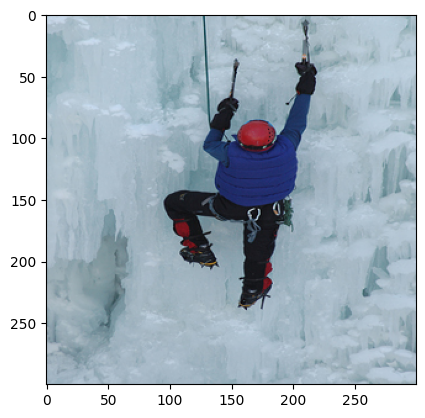

/content/sample_data/Images/97577988_65e2eae14a.jpg (similarity: 0.049854639917612076)


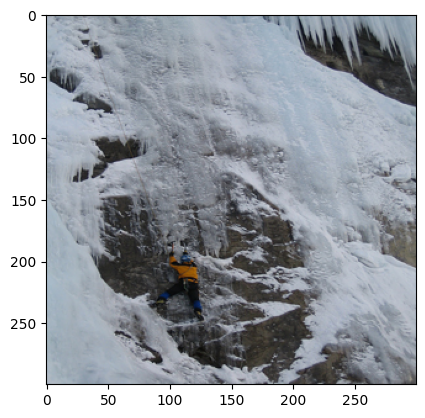

/content/sample_data/Images/93922153_8d831f7f01.jpg (similarity: 0.036333050578832626)


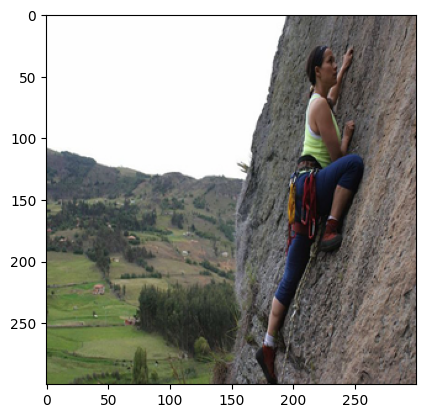

/content/sample_data/Images/118187095_d422383c81.jpg (similarity: 0.02722480334341526)


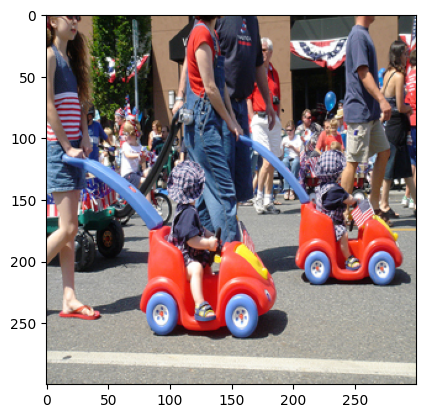

In [ ]:
# function for BLIP:
!pip install faiss-cpu --quiet
# !pip install faiss-gpu # faiss-gpu could not be installed in this environment
!pip install "numpy<2.0"

import PIL.Image # Explicitly import Image from PIL
import requests
# Changed from BlipModel to BlipForConditionalGeneration as suggested in the warning message, and the correct model
from transformers import BlipProcessor, BlipForConditionalGeneration, BlipForImageTextRetrieval
import torch
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
from datasets import Dataset # Keep Dataset from datasets
from torch.utils.data import DataLoader
from typing import List, Union, Tuple
import faiss
import numpy as np

from huggingface_hub import notebook_login

notebook_login()

# define the image paths and captions
data_dir = "/content/sample_data/Images"
image_paths = [
    os.path.join(data_dir, fname)
    for fname in os.listdir(data_dir)
    if fname.lower().endswith((".jpg", ".jpeg", ".png"))
]
image_paths.sort()
captions_df = pd.read_csv('/content/sample_data/captions.txt')

if not image_paths:
    print("Error: No images found in the specified directory. Please ensure the dataset is downloaded and unzipped correctly.")
else:
    # Changed the model name to a BLIP model suitable for image-text retrieval
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")
    model = model.to(device)
    processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")

    def encode_images_BLIP(image_paths):
        image_embeddings = []
        for image_path in tqdm(image_paths):
            try:
                image = PIL.Image.open(image_path).convert("RGB")
                inputs = processor(images=image, return_tensors="pt").to(device)
                with torch.no_grad():
                    vision_outputs = model.vision_model(**inputs)
                    image_embeds = vision_outputs.last_hidden_state[:, 0, :]  # CLS token
                    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
                    image_embeddings.append(image_embeds.cpu().numpy())
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                continue

        if len(image_embeddings) == 0:
            raise ValueError("No embeddings generated. Check image paths or formats.")
        return np.vstack(image_embeddings)


    # the function returns a numpy array with the image embeddings
    vector_embedding = encode_images_BLIP(image_paths)


    with open('flicker8k_image_embeddings.pkl','wb') as f:
        pickle.dump(vector_embedding, f)

    import pickle
    with open('flicker8k_image_embeddings.pkl', 'rb') as fp:
        vector_embedding = pickle.load(fp)


    index = faiss.IndexFlatIP(vector_embedding.shape[1])
    # add the image embeddings to the index
    index.add(vector_embedding)

    def Search(search_text, results):
        # Use the processor to encode text for BLIP
        text_inputs = processor(text=search_text, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            text_outputs = model.text_encoder(
                input_ids=text_inputs.input_ids,
                attention_mask=text_inputs.attention_mask,
                return_dict=True
            )
            text_embeds = text_outputs.last_hidden_state[:, 0, :]  # CLS token
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
            text_search_embedding = text_embeds.cpu().numpy()

        # perform FAISS search
        distances, indices = index.search(text_search_embedding.reshape(1, -1), results)

        # display results
        fixed_size = (300, 300)
        for idx, distance in zip(indices[0], distances[0]):
            print(f"{image_paths[idx]} (similarity: {distance})")
            im = PIL.Image.open(image_paths[idx])
            im_resized = im.resize(fixed_size)
            plt.imshow(im_resized)
            plt.show()

    search_text = "football"
    results = 4
    Search(search_text, results)

# Q4 Recommender System

#Answer to Question: (4a)

key components of recommender system architecture are as follows:

i) In Item Data representation layer, we preprocess raw data. Then we normalize, tokenize, and vectorize them.

ii) In similarity computation layer, we compute the pairwise similarity between items using Cosine similarity or Jaccard similarity.

iii) Item-item similarity matrix, where two similar items asre saved as pairs in matrix form.

iv) In Recommendation layer, we compare the customer items with top 'n' items which are similar to the item and retrieve them.

v) In Evaluation Module, we evaluate the precision of the recommendations.

#Answer to question: (4b)

In [ ]:
# function to preprocess
# Download the dataset if it doesn't exist
import os
if not os.path.exists("ml-100k.zip"):
    !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

!unzip -o ml-100k.zip -d .
from sklearn.metrics.pairwise import pairwise_distances
from heapq import nlargest
from sklearn.metrics import mean_squared_error
from math import sqrt
import os.path
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess(data):
    cleaned_data = []
    # Check if data is a pandas Series or list of strings before iterating
    if isinstance(data, pd.Series):
        data_list = data.tolist()
    elif isinstance(data, list):
        data_list = data
    else:
        # Handle other data types or raise an error
        raise TypeError("Input data must be a pandas Series or a list of strings")


    for row in data_list:
        # Ensure row is a string before applying string methods
        if isinstance(row, str):
            row = row.strip().lower()
            # applied regex to filter out all non-alphabetical characters
            row = re.sub(r'[^a-zA-Z0-9\s]', '', row)
            cleaned_data.append(row)
        else:
            # Handle non-string elements if necessary
            print(f"Warning: Skipping non-string element in data: {row}")
            continue


    vectorize = TfidfVectorizer(stop_words='english')
    tfidmatrix = vectorize.fit_transform(cleaned_data)

    return tfidmatrix, vectorize

# implement function just for example below
MOVIELENS_DIR = "ml-100k/"
!ls $MOVIELENS_DIR

fields = ['userID', 'itemID', 'rating', 'timestamp']
ratingDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.data'), sep='\t', names=fields)

fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

# Applying the preprocess function to the 'movieTitle' column of moviesDF
movie_titles_matrix, movie_title_vectorizer = preprocess(moviesDF['movieTitle'])


print("Dataset loaded and movie titles preprocessed successfully.")
print("Shape of movie titles matrix:", movie_titles_matrix.shape)

Archive:  ml-100k.zip
  inflating: ./ml-100k/allbut.pl     
  inflating: ./ml-100k/mku.sh        
  inflating: ./ml-100k/README        
  inflating: ./ml-100k/u.data        
  inflating: ./ml-100k/u.genre       
  inflating: ./ml-100k/u.info        
  inflating: ./ml-100k/u.item        
  inflating: ./ml-100k/u.occupation  
  inflating: ./ml-100k/u.user        
  inflating: ./ml-100k/u1.base       
  inflating: ./ml-100k/u1.test       
  inflating: ./ml-100k/u2.base       
  inflating: ./ml-100k/u2.test       
  inflating: ./ml-100k/u3.base       
  inflating: ./ml-100k/u3.test       
  inflating: ./ml-100k/u4.base       
  inflating: ./ml-100k/u4.test       
  inflating: ./ml-100k/u5.base       
  inflating: ./ml-100k/u5.test       
  inflating: ./ml-100k/ua.base       
  inflating: ./ml-100k/ua.test       
  inflating: ./ml-100k/ub.base       
  inflating: ./ml-100k/ub.test       
allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base 

#Answer to Question: (4c)

In [ ]:
# function to compute the similarity matrix between item
def compute_similarity_matrix(matrix):
    # Removed the incorrect call to preprocess
    similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')

    similarity_matrix = similarity_matrix.copy()
    m,n = similarity_matrix.shape
    for i in range(m):
        for j in range(n):
            if i == j:
                similarity_matrix[i][j] = 0


    return similarity_matrix


#Answer to question: (4d)


In [ ]:
# predict ratings in a collaborative filtering context based on user similarity
def predictByUserSimilarity(trainSet, similarity, k=None):
    """
    trainSet: 2D numpy array of shape (numUsers, numItems)
              Rows = users, Columns = items, Values = ratings (0 if unrated)
    similarity: 2D numpy array of shape (numUsers, numUsers)
                Similarity between users
    k: (optional) number of top similar users to consider
    """
    # Ensure trainSet is a numpy array and is 2D
    trainSet = np.array(trainSet)
    if trainSet.ndim != 2:
        raise ValueError(f"trainSet must be 2D. Got shape {trainSet.shape}")

    numUsers, numItems = trainSet.shape

    # Ensure similarity is a numpy array
    similarity = np.array(similarity)
    if similarity.ndim != 2:
        raise ValueError(f"similarity must be 2D. Got shape {similarity.shape}")

    # If k is given, we will later pick top-k neighbors
    predictionMatrix = np.zeros((numUsers, numItems))

    for user in range(numUsers):
        for item in range(numItems):
            rating = trainSet[user, item]

            if rating == 0:
                # Find other users who rated this item
                itemVector = trainSet[:, item]
                rated_by = np.where(itemVector != 0)[0]

                if len(rated_by) == 0:
                    # Nobody rated this item → fallback to user's mean
                    userRatings = trainSet[user, :]
                    ratedItems = userRatings[userRatings != 0]
                    predictionMatrix[user, item] = ratedItems.mean() if len(ratedItems) > 0 else 0
                else:
                    # Get similarities and ratings of these users
                    sims = similarity[user, rated_by]
                    ratings = itemVector[rated_by]

                    # If k is specified, take top-k similar users
                    if k is not None and k < len(sims):
                        # sort by similarity
                        top_idx = np.argsort(sims)[-k:]
                        sims = sims[top_idx]
                        ratings = ratings[top_idx]

                    # Avoid division by zero
                    if sims.sum() == 0:
                        userRatings = trainSet[user, :]
                        ratedItems = userRatings[userRatings != 0]
                        predictionMatrix[user, item] = ratedItems.mean() if len(ratedItems) > 0 else 0
                    else:
                        predictionMatrix[user, item] = np.dot(ratings, sims) / sims.sum()
            else:
                # Already rated
                predictionMatrix[user, item] = rating

        # Progress print every 100 users
        if user % 100 == 0:
            print(f"Processed user {user}")

    return predictionMatrix

# Create the user-item rating matrix
num_users = ratingDF['userID'].nunique()
num_items = ratingDF['itemID'].nunique()

user_item_matrix = np.zeros((num_users, num_items))

for index, row in ratingDF.iterrows():
    user_item_matrix[row['userID'] - 1, row['itemID'] - 1] = row['rating']

# Compute the user-user similarity matrix
user_similarity_matrix = compute_similarity_matrix(user_item_matrix)

# Predict ratings using user similarity
userSimPrediction = predictByUserSimilarity(user_item_matrix, user_similarity_matrix, k=None)

# Calculate RMSE
rmse = sqrt(mean_squared_error(user_item_matrix, userSimPrediction))
print("RMSE: "+str(rmse))

Processed user 0
Processed user 100
Processed user 200
Processed user 300
Processed user 400
Processed user 500
Processed user 600
Processed user 700
Processed user 800
Processed user 900
RMSE: 3.029422152949981


# Q5 Collaborative Filtering

#Answer to Question: (5a)

If we use the movie recommendation in the above,  Collaborating filtering uses user ratings to recommend items that the user might be interested in. It learns from the behavior of similar user items. The data used is the user-item matrix.

Whereas, content-based filtering, in the movie recommentation, used user item metadata or text to recommend items similar to their interests. It learns from the item content features.

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT:
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items

        OUTPUT:
            matrix: 2D numpy array.

        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'

        NOTE 2: data can have more columns, but your function should ignore
              additional columns.
    """
    ########### your code goes here ###########
    # We initialize the matrix with zeros
    # Our inputs: 'rating_df', 'userID', 'itemID', 'rating'
    matrix = np.zeros((num_users, num_items))

    # for each row and index in rating_df, we map 'userID' and 'itemID' to indices
    for index, row in rating_df.iterrows():
        # we set the matrix to the rating
        matrix[row['userID'] - 1, row['itemID'] - 1] = row['rating']

    # the output which is the returned matrix is user-item matrix similarity calculation

    ###########         end         ###########
    return matrix

In [ ]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }

        return switcher[method_name]

    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'
        """

        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        averageRating = 0
        for user in range(num_users):
            userRatings = train_matrix[user, :]
            ratedItems = userRatings[userRatings != 0]
            if len(ratedItems) > 0:
                averageRating = ratedItems.mean()
                predictionMatrix[user, :] = averageRating
            else:
                predictionMatrix[user, :] = 0

        ###########         end         ###########
        return predictionMatrix

    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'
        """

        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        for item in range(num_items):
            itemRatings = train_matrix[:, item]
            ratedUsers = itemRatings[itemRatings != 0]
            if len(ratedUsers) > 0:
                averageRating = ratedUsers.mean()
                predictionMatrix[:, item] = averageRating
            else:
                predictionMatrix[:, item] =0


        ###########         end         ###########
        return predictionMatrix

    def predict_all(self, train_df, num_users, num_items):

        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)

    def evaluate_test(self, test_df, copy=False):

        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df

        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")


# Answer to question: (5d)

Both uses collaborative patterns. However item-based CF outperforms user-based CF in accuracy when MovieLens datasets are passed on to the model.

To resolve the authentication issue with Hugging Face, please run the following cell to log in. You will need to enter your Hugging Face token when prompted. If you don't have a token, you can create one [here](https://huggingface.co/settings/tokens).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()